### Energy Consumption Forcasting Using PINNs

In [ ]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls /content/drive/MyDrive/DD

energy_dataset.csv  weather_features.csv


In [ ]:
import numpy as np, pandas as pd, seaborn as sns, torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd
from pysr import PySRRegressor
from torch.utils.data import Dataset, DataLoader
from geopy.geocoders import Nominatim
import plotly.express as px
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import torch.optim as optim

/usr/local/lib/python3.11/dist-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compa

In [ ]:
# load datasets
energy_df = pd.read_csv("/content/drive/MyDrive/DD/energy_dataset.csv")
weather_df = pd.read_csv("/content/drive/MyDrive/DD/weather_features.csv")
energy_df = energy_df.rename(columns={"time": "datetime"})
weather_df = weather_df.rename(columns={"dt_iso": "datetime"})
# Convert datetime columns to proper datetime format
energy_df["datetime"] = pd.to_datetime(energy_df["datetime"], utc=True)
weather_df["datetime"] = pd.to_datetime(weather_df["datetime"], utc=True)

# Sort datasets by datetime
energy_df = energy_df.sort_values("datetime")
weather_df = weather_df.sort_values("datetime")

# Remove duplicate timestamps in weather (if needed)
weather_df = weather_df.drop_duplicates(subset="datetime")
weather_df = weather_df[weather_df["datetime"].diff() != pd.Timedelta(seconds=0)]
weather_df = weather_df[weather_df["datetime"].diff().dt.total_seconds() > 0]

# Merge
merged_df = pd.merge(
    energy_df,
    weather_df,
    on="datetime",
    how="inner"
)
merged_df = merged_df.set_index("datetime").sort_index()

# Interpolate and fill missing numerical values
numeric_cols = merged_df.select_dtypes(include=['number']).columns
merged_df[numeric_cols] = merged_df[numeric_cols].interpolate(method='time')
merged_df[numeric_cols] = merged_df[numeric_cols].fillna(method='bfill').fillna(method='ffill')

print("Remaining missing values:", merged_df.isnull().sum().sum())
missing_per_column = merged_df.isnull().sum()
missing_per_column = missing_per_column[missing_per_column > 0]
if missing_per_column.empty:
    print("No missing values in any column.")
else:
    print("Missing values by column:")
    print(missing_per_column)


<ipython-input-5-807527884001>:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[numeric_cols] = merged_df[numeric_cols].fillna(method='bfill').fillna(method='ffill')


Remaining missing values: 70126
Missing values by column:
generation hydro pumped storage aggregated    35063
forecast wind offshore eday ahead             35063
dtype: int64


In [ ]:
# Make sure datetime is the index
merged_df = merged_df.sort_index()

# Extract time features
merged_df["year"] = merged_df.index.year
merged_df["month"] = merged_df.index.month
merged_df["dayofweek"] = merged_df.index.dayofweek  # Monday=0, Sunday=6
merged_df["hour"] = merged_df.index.hour

# Add is_weekend feature
merged_df["is_weekend"] = merged_df["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

# Display the first few rows to confirm
print(merged_df[["year", "month", "dayofweek", "hour", "is_weekend"]].head())

                           year  month  dayofweek  hour  is_weekend
datetime                                                           
2015-01-01 00:00:00+00:00  2015      1          3     0           0
2015-01-01 01:00:00+00:00  2015      1          3     1           0
2015-01-01 02:00:00+00:00  2015      1          3     2           0
2015-01-01 03:00:00+00:00  2015      1          3     3           0
2015-01-01 04:00:00+00:00  2015      1          3     4           0



$$
\frac{\partial L}{\partial t} = D \frac{\partial^2 L}{\partial x^2} + f(x,t)
$$





In [ ]:
merged_df['year'] = merged_df.index.year
print(merged_df['year'].value_counts().sort_index())

year
2015    8760
2016    8784
2017    8760
2018    8759
Name: count, dtype: int64


In [ ]:
merged_df.to_csv("/content/merged_dataset.csv")
from google.colab import files
files.download("/content/merged_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
reloaded_df = pd.read_csv('/content/merged_dataset.csv', parse_dates=['datetime'])
reloaded_df = reloaded_df.set_index('datetime').sort_index()
print(reloaded_df.info())
print(reloaded_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 49 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35063 non-null  float64
 1   generation fossil brown coal/lignite         35063 non-null  float64
 2   generation fossil coal-derived gas           35063 non-null  float64
 3   generation fossil gas                        35063 non-null  float64
 4   generation fossil hard coal                  35063 non-null  float64
 5   generation fossil oil                        35063 non-null  float64
 6   generation fossil oil shale                  35063 non-null  float64
 7   generation fossil peat                       35063 non-null  float64
 8   generation geothermal                        35063 non-null  float64
 9   generation hydro pumped s

In [ ]:
n_rows = merged_df.shape[0]
# Calculate % of NaNs and % of Zeros per column
nan_pct = merged_df.isna().sum() / n_rows
zero_pct = (merged_df == 0).sum() / n_rows

# Combine both NaN% and 0% together
combined_pct = nan_pct + zero_pct
columns_to_drop = combined_pct[combined_pct > 0.3].index.tolist()

print(f"Columns with >30% NaNs or Zeros: {columns_to_drop}")
cleaned_df = merged_df.drop(columns=columns_to_drop)

print(f"Dropped {len(columns_to_drop)} columns.")
print(f"Remaining columns: {cleaned_df.shape[1]}")

Columns with >30% NaNs or Zeros: ['generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'is_weekend']
Dropped 15 columns.
Remaining columns: 34


In [ ]:
# List of columns you want to remove
columns_to_remove = [
    'generation biomass',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation nuclear',
    'generation other',
    'generation waste',
    'forecast solar day ahead',
    'forecast wind onshore day ahead',
    'temp_min',
    'temp_max',
    'wind_deg',
    'weather_id',
    'weather_main',
    'weather_description',
    'weather_icon'
]

final_cleaned_df = cleaned_df.drop(columns=columns_to_remove)
print("Columns dropped")
print(f"Remaining columns: {list(final_cleaned_df.columns)}")

Columns dropped
Remaining columns: ['generation other renewable', 'generation solar', 'generation wind onshore', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'city_name', 'temp', 'pressure', 'humidity', 'wind_speed', 'year', 'month', 'dayofweek', 'hour']


In [ ]:
final_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   generation other renewable  35063 non-null  float64
 1   generation solar            35063 non-null  float64
 2   generation wind onshore     35063 non-null  float64
 3   total load forecast         35063 non-null  float64
 4   total load actual           35063 non-null  float64
 5   price day ahead             35063 non-null  float64
 6   price actual                35063 non-null  float64
 7   city_name                   35063 non-null  object 
 8   temp                        35063 non-null  float64
 9   pressure                    35063 non-null  int64  
 10  humidity                    35063 non-null  int64  
 11  wind_speed                  35063 non-null  int64  
 12  year                        35063 non-nul

The evolution of the energy load over space and time can be modeled using a diffusion-type Partial Differential Equation (PDE):

$$
\frac{\partial L(x, t)}{\partial t} = D \nabla^2 L(x, t) + f(x, t)
$$


In [ ]:
!pip install geopy

In [ ]:
cities = final_cleaned_df['city_name'].unique()
geolocator = Nominatim(user_agent="city_locator")

# Function to get coordinates
def get_coordinates(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])
city_coords = pd.DataFrame(cities, columns=["city_name"])
city_coords[["latitude", "longitude"]] = city_coords["city_name"].apply(get_coordinates)

# Merge coordinates back into your dataset
final_cleaned_df = final_cleaned_df.merge(city_coords, on="city_name", how="left")

print(final_cleaned_df[['city_name', 'latitude', 'longitude']].drop_duplicates())

    city_name   latitude  longitude
0   Barcelona  41.382894   2.177432
2    Valencia  39.469707  -0.376335
3      Bilbao  43.263002  -2.935004
6     Seville  37.388630  -5.995340
8      Madrid  40.416705  -3.703582


In [ ]:
print("DataFrame Info Summary:\n")
print(f"Total Rows: {final_cleaned_df.shape[0]}\n")

for col in final_cleaned_df.columns:
    total_rows = final_cleaned_df.shape[0]
    non_missing_rows = final_cleaned_df[col].count()
    missing_rows = total_rows - non_missing_rows
    dtype = final_cleaned_df[col].dtype
    print(f"{col:<30} Non-Null: {non_missing_rows:<6} Missing: {missing_rows:<6} Dtype: {dtype}")

DataFrame Info Summary:

Total Rows: 35063

generation other renewable     Non-Null: 35063  Missing: 0      Dtype: float64
generation solar               Non-Null: 35063  Missing: 0      Dtype: float64
generation wind onshore        Non-Null: 35063  Missing: 0      Dtype: float64
total load forecast            Non-Null: 35063  Missing: 0      Dtype: float64
total load actual              Non-Null: 35063  Missing: 0      Dtype: float64
price day ahead                Non-Null: 35063  Missing: 0      Dtype: float64
price actual                   Non-Null: 35063  Missing: 0      Dtype: float64
city_name                      Non-Null: 35063  Missing: 0      Dtype: object
temp                           Non-Null: 35063  Missing: 0      Dtype: float64
pressure                       Non-Null: 35063  Missing: 0      Dtype: int64
humidity                       Non-Null: 35063  Missing: 0      Dtype: int64
wind_speed                     Non-Null: 35063  Missing: 0      Dtype: int64
year           

In [ ]:
cities_with_missing_lat = final_cleaned_df[final_cleaned_df['latitude'].isna()]['city_name'].unique()
print("Cities with missing latitude:", cities_with_missing_lat)

Cities with missing latitude: []


In [ ]:
final_cleaned_df.loc[final_cleaned_df['city_name'] == 'Bilbao', 'latitude'] = 43.2630
final_cleaned_df.loc[final_cleaned_df['city_name'] == 'Bilbao', 'longitude'] = -2.9350

In [ ]:
print(final_cleaned_df[['latitude', 'longitude']].isna().sum())

latitude     0
longitude    0
dtype: int64


In [ ]:
final_cleaned_df.loc[final_cleaned_df['city_name'] == 'Bilbao', 'latitude'] = 43.2630
final_cleaned_df.loc[final_cleaned_df['city_name'] == 'Bilbao', 'longitude'] = -2.9350

city_load = final_cleaned_df.groupby(['city_name', 'latitude', 'longitude'])['total load actual'].mean().reset_index()
city_load = city_load.rename(columns={'total load actual': 'avg_load'})


fig = px.scatter_geo(
    city_load,
    lat='latitude',
    lon='longitude',
    text='city_name',
    color='avg_load',
    size='avg_load',
    color_continuous_scale='YlOrRd',
    projection='natural earth',
    title='Average Energy Load per City'
)
fig.update_traces(marker=dict(line=dict(width=0.5, color='black')))
fig.update_layout(
    geo=dict(
        scope='europe',
        center=dict(lat=40.0, lon=-3.7),
        projection_scale=5,
        showland=True,
        landcolor='rgb(243, 243, 243)'
    )
)
fig.show()

## 1. Energy Diffusion Equation

The primary physical model assumes that the energy load evolves over space and time according to a diffusion-type Partial Differential Equation (PDE) with external forcing:

$$
\frac{\partial L(x, t)}{\partial t} = D \nabla^2 L(x, t) + f(x, t)
$$

## 2. Energy Conservation Law

Energy generation and consumption should approximately balance over time. We introduce an energy conservation constraint:

$$
L(x, t) \approx G_{\text{solar}}(x, t) + G_{\text{wind}}(x, t) + G_{\text{renewable}}(x, t)
$$

## 3. Seasonality Constraint

Electricity demand exhibits natural seasonal variations. We encode seasonality by enforcing that:

- Higher demand is expected during winter (heating loads) and summer (cooling loads),
- Moderate demand during spring and fall.

This can be incorporated as a soft constraint or as part of the external forcing term \( f(x, t) \).

---

## 4. Temperature-Load Sensitivity

There exists a nonlinear relationship between temperature and energy load:

- When the temperature is very **low** (cold seasons) or **very high** (hot seasons), the load tends to **increase**.

We enforce the following qualitative behavior:

$$
\frac{\partial L(x, t)}{\partial \text{temp}(x, t)} > 0 \quad \text{for} \quad \text{temp} < 10^\circ C \quad \text{or} \quad \text{temp} > 25^\circ C
$$

---

## 5. Wind Generation Relationship

Wind energy generation is positively correlated with wind speed. We enforce:

$$
\frac{\partial G_{\text{wind}}(x, t)}{\partial \text{wind speed}(x, t)} > 0
$$

This constraint ensures that the model respects basic physical behavior for wind-based energy generation.

---

Modeling Using PINNs

In [ ]:
print("DataFrame Info Summary:\n")
print(f"Total Rows: {final_cleaned_df.shape[0]}\n")

for col in final_cleaned_df.columns:
    total_rows = final_cleaned_df.shape[0]
    non_missing_rows = final_cleaned_df[col].count()
    missing_rows = total_rows - non_missing_rows
    dtype = final_cleaned_df[col].dtype
    print(f"{col:<30} Non-Null: {non_missing_rows:<6} Missing: {missing_rows:<6} Dtype: {dtype}")


DataFrame Info Summary:

Total Rows: 35063

generation other renewable     Non-Null: 35063  Missing: 0      Dtype: float64
generation solar               Non-Null: 35063  Missing: 0      Dtype: float64
generation wind onshore        Non-Null: 35063  Missing: 0      Dtype: float64
total load forecast            Non-Null: 35063  Missing: 0      Dtype: float64
total load actual              Non-Null: 35063  Missing: 0      Dtype: float64
price day ahead                Non-Null: 35063  Missing: 0      Dtype: float64
price actual                   Non-Null: 35063  Missing: 0      Dtype: float64
city_name                      Non-Null: 35063  Missing: 0      Dtype: object
temp                           Non-Null: 35063  Missing: 0      Dtype: float64
pressure                       Non-Null: 35063  Missing: 0      Dtype: int64
humidity                       Non-Null: 35063  Missing: 0      Dtype: int64
wind_speed                     Non-Null: 35063  Missing: 0      Dtype: int64
year           

In [ ]:
input_features = [
    'temp', 'pressure', 'humidity', 'wind_speed',
    'generation other renewable', 'generation solar', 'generation wind onshore',
    'latitude', 'longitude', 'hour', 'dayofweek', 'month'
]

target_feature = 'total load actual'
# Split the data
train_df = final_cleaned_df[(final_cleaned_df['year'] == 2015) | (final_cleaned_df['year'] == 2016)]
test_df = final_cleaned_df[(final_cleaned_df['year'] == 2017)]

X_train = train_df[input_features].values
y_train = train_df[target_feature].values.reshape(-1, 1)

X_test = test_df[input_features].values
y_test = test_df[target_feature].values.reshape(-1, 1)
print("Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes:
X_train: (17544, 12), y_train: (17544, 1)
X_test: (8760, 12), y_test: (8760, 1)


In [ ]:
class SimplePINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(SimplePINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

## ***Physics-Informed Loss***

Data loss | Standard MSE between prediction and ground truth

Energy conservation | Load ≈ Sum of energy generation

Seasonality | Penalty for deviation in extreme months

Temperature sensitivity | Load increases for very cold (<10°C) or hot (>25°C)

Wind generation relation | Wind energy should increase with wind speed

In [ ]:
def pinn_loss(model, X, y_true):
    y_pred = model(X)

    # Data loss (supervised)
    mse_loss = nn.MSELoss()
    data_loss = mse_loss(y_pred, y_true)

    # Energy conservation loss
    solar = X[:, input_features.index('generation solar')]
    wind = X[:, input_features.index('generation wind onshore')]
    renewable = X[:, input_features.index('generation other renewable')]
    conservation_target = solar + wind + renewable
    conservation_loss = mse_loss(y_pred.squeeze(), conservation_target)

    # Seasonality loss
    month = X[:, input_features.index('month')]
    seasonal_weight = ((month == 1) | (month == 2) | (month == 7) | (month == 8)).float() * 1.5 + 1.0
    seasonality_loss = mse_loss(y_pred.squeeze() * seasonal_weight, y_true.squeeze() * seasonal_weight)

    # Temperature sensitivity loss
    temp = X[:, input_features.index('temp')]
    grad_temp = torch.autograd.grad(outputs=y_pred, inputs=X,
                                    grad_outputs=torch.ones_like(y_pred),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0][:, input_features.index('temp')]
    temp_sensitivity_loss = torch.mean(torch.relu(-grad_temp[(temp < 10) | (temp > 25)]))

    # Wind generation relationship loss
    wind_speed = X[:, input_features.index('wind_speed')]
    grad_wind = torch.autograd.grad(outputs=wind, inputs=X,
                                    grad_outputs=torch.ones_like(wind),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0][:, input_features.index('wind_speed')]
    wind_sensitivity_loss = torch.mean(torch.relu(-grad_wind))

    # Total loss
    total_loss = data_loss + conservation_loss + seasonality_loss + temp_sensitivity_loss + wind_sensitivity_loss

    return total_loss

In [ ]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

# Output scaler
output_scaler = StandardScaler()
y_train_scaled = output_scaler.fit_transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, requires_grad=True)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [ ]:
input_dim = len(input_features)
model = SimplePINN(input_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, X_train_tensor, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 4.616847
Epoch 500, Loss: 1.787657
Epoch 1000, Loss: 1.716653
Epoch 1500, Loss: 1.645856
Epoch 2000, Loss: 1.609150
Epoch 2500, Loss: 1.583074
Epoch 3000, Loss: 1.561163
Epoch 3500, Loss: 1.541929
Epoch 4000, Loss: 1.525815
Epoch 4500, Loss: 1.511431


In [ ]:
# Predict
model.eval()
y_pred_scaled = model(X_test_tensor).detach().numpy()

# Inverse transform to get original scale
y_pred = output_scaler.inverse_transform(y_pred_scaled)
y_true = output_scaler.inverse_transform(y_test_scaled)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
mean_true = y_true.mean()
cv = rmse / mean_true  # Coefficient of Variation

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"CV: {cv:.4f}")
print(f"MRMSE (Mean Relative RMSE): {(rmse / mean_true) * 100:.2f}%")

MAE: 3622.65
R²: 0.0097
RMSE: 4535.70
CV: 0.1572
MRMSE (Mean Relative RMSE): 15.72%


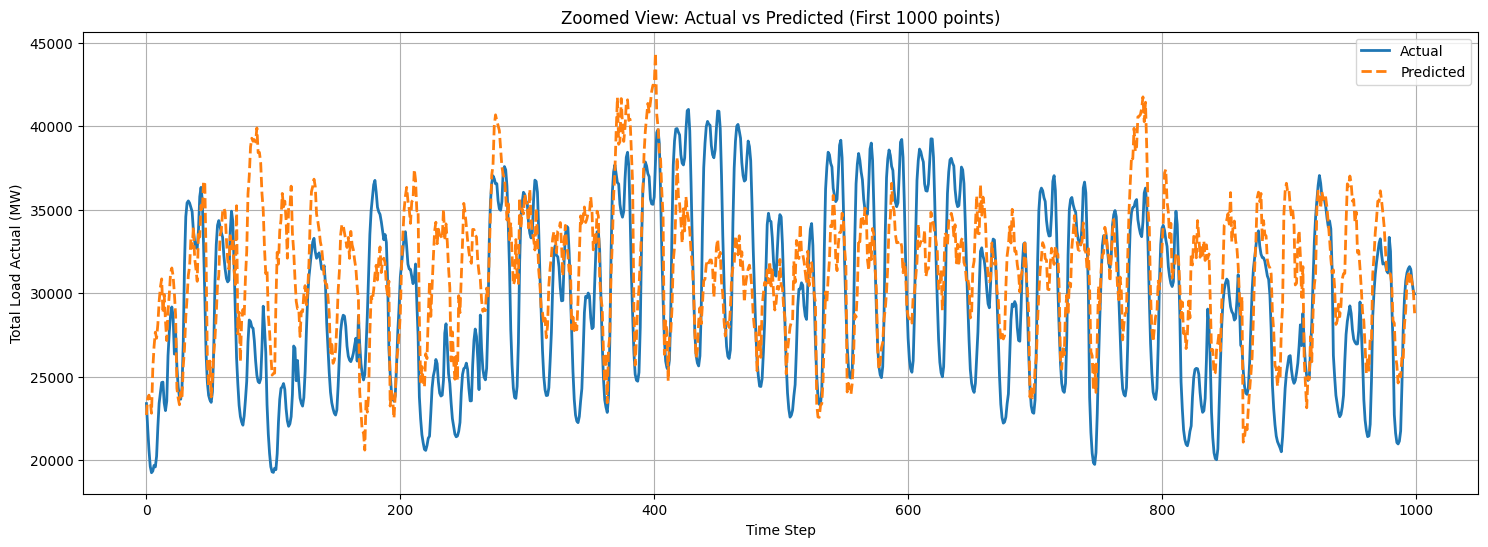

In [ ]:
# Zoom into first 1000 points
plt.figure(figsize=(18, 6))
plt.plot(y_true[:1000], label='Actual', linewidth=2)
plt.plot(y_pred[:1000], label='Predicted', linestyle='--', linewidth=2)
plt.title('Zoomed View: Actual vs Predicted (First 1000 points)')
plt.xlabel('Time Step')
plt.ylabel('Total Load Actual (MW)')
plt.legend()
plt.grid(True)
plt.show()

-----------------------------------------------------------------

In [ ]:
# Add 'is_weekend' if missing
if 'is_weekend' not in final_cleaned_df.columns:
    final_cleaned_df['is_weekend'] = final_cleaned_df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Then split into Train and Test
train_df = final_cleaned_df[(final_cleaned_df['year'] == 2015) | (final_cleaned_df['year'] == 2016)]
test_df = final_cleaned_df[(final_cleaned_df['year'] == 2017)]

# Now prepare X_train and X_test
X_train = train_df[input_features].values
y_train = train_df[[target_feature]].values

X_test = test_df[input_features].values
y_test = test_df[[target_feature]].values


In [ ]:
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

y_train_scaled = output_scaler.fit_transform(y_train)
y_test_scaled = output_scaler.transform(y_test)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ========== Step 1: Define Input Features ==========
input_features = [
    'temp', 'pressure', 'humidity', 'wind_speed',
    'generation other renewable', 'generation solar', 'generation wind onshore',
    'latitude', 'longitude', 'hour', 'dayofweek', 'is_weekend', 'month'
]
target_feature = 'total load actual'

input_dim = len(input_features)

# ========== Step 2: Normalize Features ==========
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

y_train_scaled = output_scaler.fit_transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

# ========== Step 3: Create Sequences for LSTM ==========
def create_sequences(X, y, seq_length=24):
    X_seq = []
    y_seq = []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return torch.tensor(X_seq, dtype=torch.float32, requires_grad=True), torch.tensor(y_seq, dtype=torch.float32)

seq_length = 24  # past 24 hours

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# ========== Step 4: Define the LSTM-PINN Model ==========
class LSTMPINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1, output_dim=1):
        super(LSTMPINN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_seq):
        lstm_out, _ = self.lstm(x_seq)
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        return out

# ========== Step 5: Define the LSTM PINN Loss ==========
def lstm_pinn_loss(model, X_seq, y_true, physics_weight=1.0):
    y_pred = model(X_seq)

    mse_loss = nn.MSELoss()
    data_loss = mse_loss(y_pred, y_true)

    # Physics Constraints
    solar = X_seq[:, -1, input_features.index('generation solar')]
    wind = X_seq[:, -1, input_features.index('generation wind onshore')]
    renewable = X_seq[:, -1, input_features.index('generation other renewable')]
    conservation_target = solar + wind + renewable
    conservation_loss = mse_loss(y_pred.squeeze(), conservation_target)

    month = X_seq[:, -1, input_features.index('month')]
    seasonal_weight = ((month == 1) | (month == 2) | (month == 7) | (month == 8)).float() * 1.5 + 1.0
    seasonality_loss = mse_loss(y_pred.squeeze() * seasonal_weight, y_true.squeeze() * seasonal_weight)

    temp = X_seq[:, -1, input_features.index('temp')]
    grad_temp = torch.autograd.grad(outputs=y_pred, inputs=X_seq,
                                    grad_outputs=torch.ones_like(y_pred),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0][:, -1, input_features.index('temp')]
    temp_sensitivity_loss = torch.mean(torch.relu(-grad_temp[(temp < 10) | (temp > 25)]))

    physics_loss = conservation_loss + seasonality_loss + temp_sensitivity_loss

    total_loss = data_loss + physics_weight * physics_loss

    return total_loss, data_loss, physics_loss

# ========== Step 6: Instantiate Model and Optimizer ==========
model = LSTMPINN(input_dim, hidden_dim=32, num_layers=1)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

# ========== Step 7: Training ==========
epochs = 8000
physics_weight = 1.0  # you can adjust this later

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = lstm_pinn_loss(model, X_train_seq, y_train_seq, physics_weight)
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.6f}, Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}")

# ========== Step 8: Evaluation ==========
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_seq).detach().numpy()

y_pred = output_scaler.inverse_transform(y_pred_scaled)
y_true = output_scaler.inverse_transform(y_test_seq.numpy())

# Metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
mean_true = y_true.mean()
cv = rmse / mean_true
mrmse = (rmse / mean_true) * 100

print("\n===== Evaluation Metrics =====")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"CV: {cv:.4f}")
print(f"MRMSE (Mean Relative RMSE): {mrmse:.2f}%")

# ========== Step 9: Plot Actual vs Predicted ==========
plt.figure(figsize=(18, 6))
plt.plot(y_true, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Total Load (LSTM-PINN)')
plt.xlabel('Time Step')
plt.ylabel('Total Load Actual (MW)')
plt.legend()
plt.grid(True)
plt.show()


Epoch 0, Total Loss: 4.233271, Data Loss: 0.998153, Physics Loss: 3.235118
Epoch 500, Total Loss: 1.616846, Data Loss: 0.375019, Physics Loss: 1.241827
Epoch 1000, Total Loss: 1.543866, Data Loss: 0.324895, Physics Loss: 1.218971
Epoch 1500, Total Loss: 1.511526, Data Loss: 0.302878, Physics Loss: 1.208648
Epoch 2000, Total Loss: 1.491901, Data Loss: 0.289293, Physics Loss: 1.202608
Epoch 2500, Total Loss: 1.473542, Data Loss: 0.282307, Physics Loss: 1.191235
Epoch 3000, Total Loss: 1.466927, Data Loss: 0.275968, Physics Loss: 1.190959
Epoch 3500, Total Loss: 1.460462, Data Loss: 0.272182, Physics Loss: 1.188280
Epoch 4000, Total Loss: 1.455293, Data Loss: 0.269325, Physics Loss: 1.185969
Epoch 4500, Total Loss: 1.450437, Data Loss: 0.267601, Physics Loss: 1.182837
Epoch 5000, Total Loss: 1.447138, Data Loss: 0.265421, Physics Loss: 1.181717
Epoch 5500, Total Loss: 1.442599, Data Loss: 0.264306, Physics Loss: 1.178293
Epoch 6000, Total Loss: 1.440672, Data Loss: 0.264965, Physics Loss:

In [ ]:
class LSTMPINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMPINN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_seq):
        lstm_out, _ = self.lstm(x_seq)
        # Only take the last time step output
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        return out

In [ ]:
import torch
import torch.nn as nn
# Safer small model
model = LSTMPINN(input_dim, hidden_dim=32, num_layers=1)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optional: Gradient clipping in training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = lstm_pinn_loss(model, X_train_seq, y_train_seq, physics_weight)
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.6f}, Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}")


NameError: name 'input_dim' is not defined

In [ ]:
class LSTMPINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMPINN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_seq):
        lstm_out, _ = self.lstm(x_seq)
        # Only take the last time step output
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        return out


In [ ]:
def create_sequences(X, y, seq_length=24):
    X_seq = []
    y_seq = []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return torch.tensor(X_seq, dtype=torch.float32, requires_grad=True), torch.tensor(y_seq, dtype=torch.float32)


In [ ]:
def lstm_pinn_loss(model, X_seq, y_true, physics_weight=1.0):
    y_pred = model(X_seq)

    mse_loss = nn.MSELoss()
    data_loss = mse_loss(y_pred, y_true)

    # Physics constraints on y_pred
    conservation_loss = torch.mean((y_pred.squeeze() - (X_seq[:, -1, input_features.index('generation solar')] +
                                                         X_seq[:, -1, input_features.index('generation wind onshore')] +
                                                         X_seq[:, -1, input_features.index('generation other renewable')]))**2)

    # Seasonality effect
    month = X_seq[:, -1, input_features.index('month')]
    seasonal_weight = ((month == 1) | (month == 2) | (month == 7) | (month == 8)).float() * 1.5 + 1.0
    seasonality_loss = mse_loss(y_pred.squeeze() * seasonal_weight, y_true.squeeze() * seasonal_weight)

    # Temperature-load sensitivity
    temp = X_seq[:, -1, input_features.index('temp')]
    grad_temp = torch.autograd.grad(outputs=y_pred, inputs=X_seq,
                                    grad_outputs=torch.ones_like(y_pred),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0][:, -1, input_features.index('temp')]
    temp_sensitivity_loss = torch.mean(torch.relu(-grad_temp[(temp < 10) | (temp > 25)]))

    # Total physics loss
    physics_loss = conservation_loss + seasonality_loss + temp_sensitivity_loss

    total_loss = data_loss + physics_weight * physics_loss

    return total_loss, data_loss, physics_loss


In [ ]:
# Prepare sequences
seq_length = 24  # Past 24 hours
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# Instantiate model
input_dim = len(input_features)
model = LSTMPINN(input_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

epochs = 8000
physics_weight = 1.0

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = lstm_pinn_loss(model, X_train_seq, y_train_seq, physics_weight)
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.6f}, Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}")

<ipython-input-91-9d8b41353961>:7: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)



Epoch 0, Total Loss: 4.228313, Data Loss: 0.995458, Physics Loss: 3.232856
